<a href="https://colab.research.google.com/github/mishrap9/Introduction-to-Deep-Learning/blob/master/cifar_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook classifies images of CIFAR-10 dataset using ResNet

## Importing the libraries required for this task

In [1]:
import numpy as np
import os
import pandas as pd
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
#from tqdm import tqdm

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

## Setting the device to GPU if available, otherwise CPU

In [3]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

## The image is normalized below

In [5]:
transform = transforms.Compose([transforms.ToTensor(),\
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_train = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])

## The data is downloaded and loaded below in batches

In [6]:
train_batch_size = 64
val_batch_size = 50

trainset = torchvision.datasets.CIFAR10(root = './data',\
                                       train = True, download = True, transform = transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = train_batch_size, shuffle = True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root = './data',\
                                      train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = val_batch_size, shuffle = False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Cell below is used for displaying the images

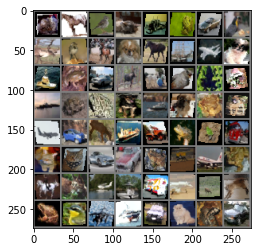

  cat horse  bird   cat truck  frog   car  bird  deer  bird horse   dog horse  ship plane   dog  ship  frog   car  deer horse  bird  frog  frog  ship  frog  frog   dog  ship   dog  frog   dog plane   car  deer  ship truck  frog  frog truck   cat   cat   car   car  frog horse plane  frog horse   cat plane  ship truck plane  deer   cat  frog  bird plane  ship   car   cat  frog   car


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    """This function displays the image from the dataset
    Arguments:
        img: image to be displayed
    """
    # unnormalize
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(train_batch_size)))

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

### Block which is used in ResNet with 18 and 34 layers.

In [9]:
class BasicBlock(nn.Module):
    """This class builds the blocks which are used in ResNet with 18 layers and 34 layers"""
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        """This is an init funtion fot class BasicBlock
        Arguments:
            in_planes: input channels
            planes: output channels
            stride: number of strides
        """
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        """This function works on all the layers defined architecture of BasicBlock of ResNet with 18 layers and 34 layers
        Arguments:
            x: input in the layer
        Return:
            out: output of the block
        """
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


### Block which is used in ResNet with 50, 101, and 152 layers.

In [10]:
class Block(nn.Module):
    """This class builds the blocks which are used in ResNet with 50 layers, 101 layers, and 152 layers."""
    expansion = 4
    def __init__(self, in_planes, planes, stride=1):
        """This is an init funtion fot class Block
        Arguments:
            in_planes: input channels
            planes: output channels
            stride: number of strides
        """
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        """This function works on all the layers defined architecture of Block of ResNet with 50 layers, 101 layers, and 152 layers.
        Arguments:
            x: input in the layer
        Return:
            out: output of the block
        """
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


### ResNet architecture

In [26]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        """This is an init funtion fot class ResNet which defines the whole architecture
        Arguments:
            block: type of block used out of BasicBlock and Block depending on the ResNet variant.
            num_blocks: list of number of layers for each block
            num_classes: number of classes, which is 10 for CIFAR-10 dataset
        """
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.dropout = nn.Dropout(0.25)

    def _make_layer(self, block, planes, num_blocks, stride):
        """This function computes the number of channels in the output of passing through the layer
        Arguments:
            block: type of block used out of BasicBlock and Block depending on the ResNet variant
            planes: input channels
            num_blocks: number of channels for each kernel
            stride: stride of the kernel
        Returns:
            nn.Sequential(*layers):  output of the layer
        """
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        """This function works on all the layers defined architecture of ResNet.
        Arguments:
            x: input in the layer
        Return:
            out: output of the block
        """
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        return out

def ResNet18():
    """Function for ResNet-18"""
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    """Function for ResNet-34"""
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    """Function for ResNet-50"""
    return ResNet(Block, [3, 4, 6, 3])


def ResNet101():
    """Function for ResNet-101"""
    return ResNet(Block, [3, 4, 23, 3])


def ResNet152():
    """Function for ResNet-152"""
    return ResNet(Block, [3, 8, 36, 3])


In [32]:
best_acc = 0
net = ResNet34()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

## Loss function used for the classification

In [33]:
import torch.optim as optim

# using Cross-Entropy Loss for classification problem
criterion = nn.CrossEntropyLoss()
grad_clip = 0.1
# optimizer used for classification
#optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay = 5e-4)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.0005, weight_decay = 1e-4)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Training the network

In [34]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        # Gradient clipping
        if grad_clip: 
            nn.utils.clip_grad_value_(net.parameters(), grad_clip)

        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        #if batch_idx%500 ==0:
    print('Training loss: %.3f  |  Training Accuracy: %.3f' %
              (train_loss/(batch_idx+1), 100.*correct/total))


In [35]:
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            #if batch_idx%500 ==0:
        print('Test loss: %.3f  |  Test Accuracy: %.3f' %
              (test_loss/(batch_idx+1), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc



In [ ]:
for epoch in range(0, 100):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 0
Training loss: 1.680  |  Training Accuracy: 38.310
Test loss: 1.661  |  Test Accuracy: 44.040
Saving..

Epoch: 1
Training loss: 1.214  |  Training Accuracy: 56.168
Test loss: 1.327  |  Test Accuracy: 59.570
Saving..

Epoch: 2
Training loss: 0.994  |  Training Accuracy: 64.878
Test loss: 1.124  |  Test Accuracy: 61.700
Saving..

Epoch: 3
Training loss: 0.847  |  Training Accuracy: 70.314
Test loss: 0.833  |  Test Accuracy: 71.130
Saving..

Epoch: 4
Training loss: 0.757  |  Training Accuracy: 73.806
Test loss: 0.712  |  Test Accuracy: 76.240
Saving..

Epoch: 5
Training loss: 0.683  |  Training Accuracy: 76.448
Test loss: 0.829  |  Test Accuracy: 74.560

Epoch: 6
Training loss: 0.633  |  Training Accuracy: 78.164
Test loss: 0.712  |  Test Accuracy: 75.160

Epoch: 7
Training loss: 0.586  |  Training Accuracy: 79.876
Test loss: 0.721  |  Test Accuracy: 76.620
Saving..

Epoch: 8
Training loss: 0.550  |  Training Accuracy: 80.818
Test loss: 0.853  |  Test Accuracy: 74.340

Epoch: 9


In [ ]:
print("Best accuracy obtained: ", best_acc)